# Application of Decision Tree and Random Forest to RMS Titanic Data

In [52]:
import os
import pydot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, cross_val_score
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree

# Turn on plots
%matplotlib inline
# Turn off warnings
pd.options.mode.chained_assignment = None  

In [38]:
# Used to Clean Data in Train and Test Set
def format_data(X):
    age_mean = np.mean(X['Age'])
    SibSp_mean = np.mean(X['SibSp'])
    Parch_mean = np.mean(X['Parch'])
    X['Age'].fillna(age_mean, inplace=True)
    X['SibSp'].fillna(SibSp_mean, inplace=True)
    X['Parch'].fillna(Parch_mean, inplace=True)
    X.loc[X['Sex'] == 'male', 'Sex'] = 0
    X.loc[X['Sex'] == 'female', 'Sex'] = 1
    return X

In [3]:
# Generate Paths to data files
root = os.getcwd()
train_file = 'train.csv'
test_file = 'test.csv'
train_data_path = os.path.join(root,train_file)
test_data_path = os.path.join(root, test_file)


In [4]:
# Load Train and Test Set
train_data = pd.read_csv(train_data_path)
test_data  = pd.read_csv(test_data_path)

In [5]:
# Declare Features and Labels
features = ['Sex', 'Age', 'SibSp', 'Parch']
labels = ['Survived']

In [41]:
# Clean and Format data for train and test set
X_train = format_data(train_data[features])
Y_train = train_data[labels]
X_test = format_data(test_data[features])
test_id = test_data['PassengerId']
cv = KFold(X_train.shape[0], n_folds = 10, shuffle=True  )

# Decision Tree Model
The code Below is used to create a decision tree and display the feature importance for the untuned Model

1. Initialize and fit Decision Tree
2. Compute Cross Validate Score
3. Visualize trained Decision Tree
4. Visualize Feature importance

In [49]:
clf1 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=4)
clf1 = clf1.fit(X_train, Y_train)

In [50]:
score = cross_val_score(clf1, X_train, Y_train, cv=cv)
print('Decision Tree Cross Validation Score: {0:5f}'.format(score.mean()))

Decision Tree Cross Validation Score: 0.818152


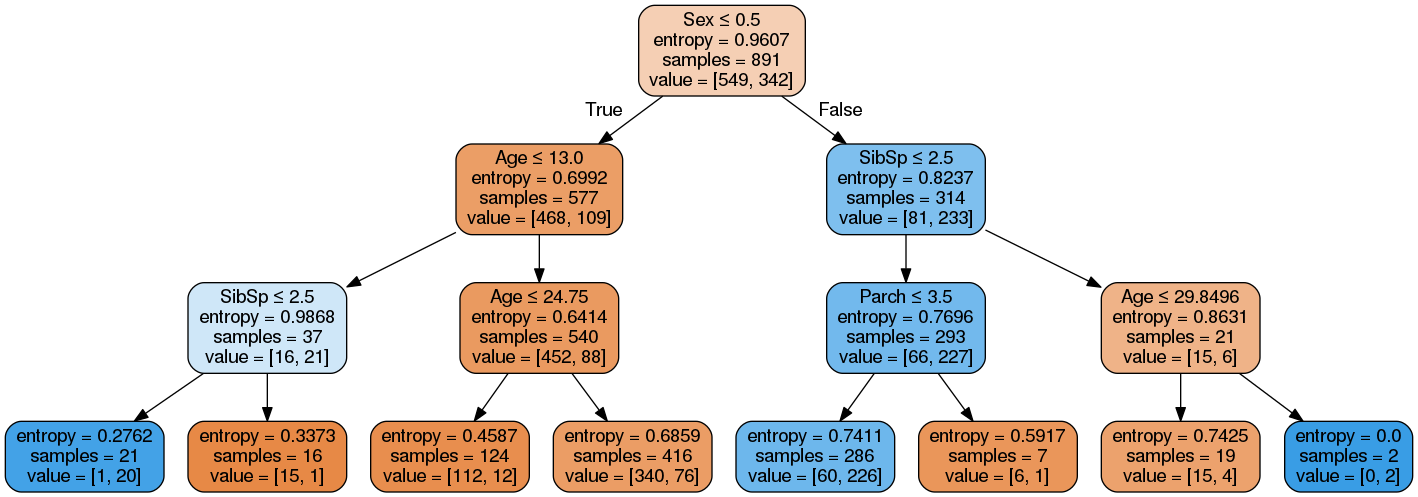

In [51]:
dot_data = StringIO()
tree.export_graphviz(clf1, out_file=dot_data,
    feature_names=X_train.columns,
    filled=True, rounded=True,
    special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

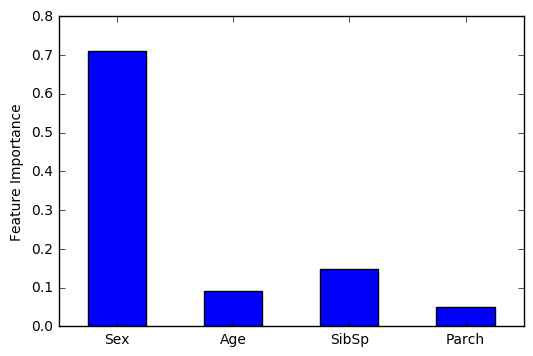

In [35]:
ypos = np.arange(len(features))
plt.bar(ypos, clf1.feature_importances_,  width=.5, align='center')
plt.xticks(ypos, features);
plt.ylabel('Feature Importance');

# Random Forest Model
 The code Below is used to create a random forest mode and display the feature importance for the untuned Model:

1. Initialize Random Forest Model 
2. Compute the cross validated score  
3. Visualize feature importance 
4. Optimize using a cross validated GridSearch. 
5. The optimized model is then stored in the variable "best_model". 
6. You can use the best model to create a submission for the kaggle Titanic Compeition
7. Your sumission will be stored in the file submission.txt

In [69]:
# Create A Random Forest Model
clf = RandomForestClassifier()
clf.fit(X_train,Y_train.values.ravel());

In [76]:
# Get Cross Validated Score for un-tuned Random Forest Model
cv = KFold(X.shape[0], n_folds = 10, shuffle=True  )
score = cross_val_score(clf, X_train, Y_train.values.ravel(),  cv=cv )
print('Cross Validation Score before adjusting HyperParameters {0:5f}'.format(score.mean()))

Cross Validation Score before adjusting HyperParameters 0.773271


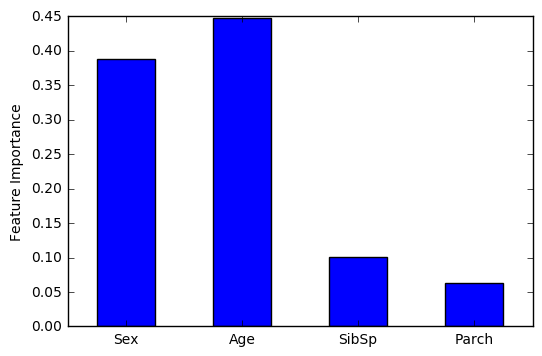

In [88]:
# Display Variable Importances
# For help with barchats see: https://pythonspot.com/matplotlib-bar-chart/
ypos = np.arange(len(features))
plt.bar(ypos, clf.feature_importances_,  width=.5, align='center')
plt.xticks(ypos, features);
plt.ylabel('Feature Importance');

In [78]:
#Optimize Parameters with GridSearch CV
from sklearn.grid_search import GridSearchCV
parameters = {'n_estimators':[10, 50, 100], 'min_samples_split':[2,3,4,8,10], 'max_depth':range(1, 5)}
grid_search = GridSearchCV(clf,parameters, cv = cv)
grid_search.fit(X,Y.values.ravel());


In [82]:
#Examine parameter values for the best model
print('Best Parameters: {0}\nBest Score: {1:5f}'.format(grid_search.best_params_, grid_search.best_score_))

Best Parameters: {'min_samples_split': 4, 'n_estimators': 100, 'max_depth': 4}
Best Score: 0.821549


In [86]:
#Use best model to predict make prediction on the test set
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

In [83]:
#To make a submission set 'submitt' to true
submitt = False
if (submitt):
    submission = pd.DataFrame({'PassengerId':test_id, 'Survived':predictions})
    submission.set_index('PassengerId', inplace=True)
    submission.to_csv('submission.txt')